<a href="https://colab.research.google.com/github/casperbh96/mbml/blob/master/recommendation_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the packages

In [53]:
# Install Pyro, if necessary
!pip install pyro-ppl

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import copy
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

pd.set_option('display.max_columns', 50)
%matplotlib inline

# Loading the dataset

This is the Santander Product Recommendation dataset from [Kaggle](https://www.kaggle.com/c/santander-product-recommendation/data).

In [55]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
#Add the path of the file "train_vers2.csv" here
#train_path = 'data/train_ver2.csv'
#train_path = '/content/gdrive/My Drive/MSc: AI/2. semester/MBML/train_ver2.csv'
train_path = '/content/gdrive/My Drive/DTU/Model-based machined learning/project/data/train_ver2.csv'

train_df = pd.read_csv(train_path, parse_dates=['fecha_dato', 'fecha_alta', 'ult_fec_cli_1t'], sep=",",na_values = ['?', 'NA'])

train_df.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaT,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaT,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaT,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


In [57]:
print(train_df.shape)

(13647309, 48)


In [0]:
columns_num = ['age',
               'renta',
               'antiguedad',
               'ncodpers']

columns_cat = ['ind_empleado',
               'pais_residencia',   
               'sexo',
               'ind_nuevo',
               'indrel',                    
               'tiprel_1mes', 
               'indresi',
               'indrel_1mes',
               'indext',
               'canal_entrada',     #The encoding creates too much columns, not very relevant (the weights are low)
               'conyuemp',           #100% of NaN values (see below)
               'indfall',
               'nomprov',
               'segmento',
               'tipodom',
               'cod_prov',
               'ind_actividad_cliente']

columns_date =['fecha_dato',
               'fecha_alta',
               'ult_fec_cli_1t']    #100% of NaN values (see below)

# Descriptive Statistics & Visualization

In [59]:
print("age value statistics", train_df['age'].describe())
print("\n \n \n renta value statistics \n\n", train_df['renta'].describe())

print("\n\n\n categorical value statistics \n\n", train_df[columns_cat].describe())
print("\n\n\n date value statistics \n\n", train_df[columns_date].describe())

age value statistics count     13647309
unique         235
top             23
freq        542682
Name: age, dtype: int64

 
 
 renta value statistics 

 count    1.085293e+07
mean     1.342543e+05
std      2.306202e+05
min      1.202730e+03
25%      6.871098e+04
50%      1.018500e+05
75%      1.559560e+05
max      2.889440e+07
Name: renta, dtype: float64



 categorical value statistics 

           ind_nuevo        indrel     tipodom      cod_prov  \
count  1.361958e+07  1.361958e+07  13619574.0  1.355372e+07   
mean   5.956184e-02  1.178399e+00         1.0  2.657147e+01   
std    2.366733e-01  4.177469e+00         0.0  1.278402e+01   
min    0.000000e+00  1.000000e+00         1.0  1.000000e+00   
25%    0.000000e+00  1.000000e+00         1.0  1.500000e+01   
50%    0.000000e+00  1.000000e+00         1.0  2.800000e+01   
75%    0.000000e+00  1.000000e+00         1.0  3.500000e+01   
max    1.000000e+00  9.900000e+01         1.0  5.200000e+01   

       ind_actividad_cliente  
count   

In [0]:
def plot_dates(datetimes, title):
    # Size of figure
    plt.figure(figsize=(15,8))

    # Plot the values
    sns.barplot(
        datetimes.index, 
        datetimes.values,
        alpha=0.7,
        color=(0, 0, 0.9)
    )

    # Make labels x: yyyymm format
    plt.xlabel('Year and month ', fontsize=16)
    plt.ylabel('Number of customers on date', fontsize=16)

    # Make xlabel vertical instead of horizontal
    plt.xticks(rotation='vertical')
    
    plt.suptitle(title, fontsize=24)

    plt.show()

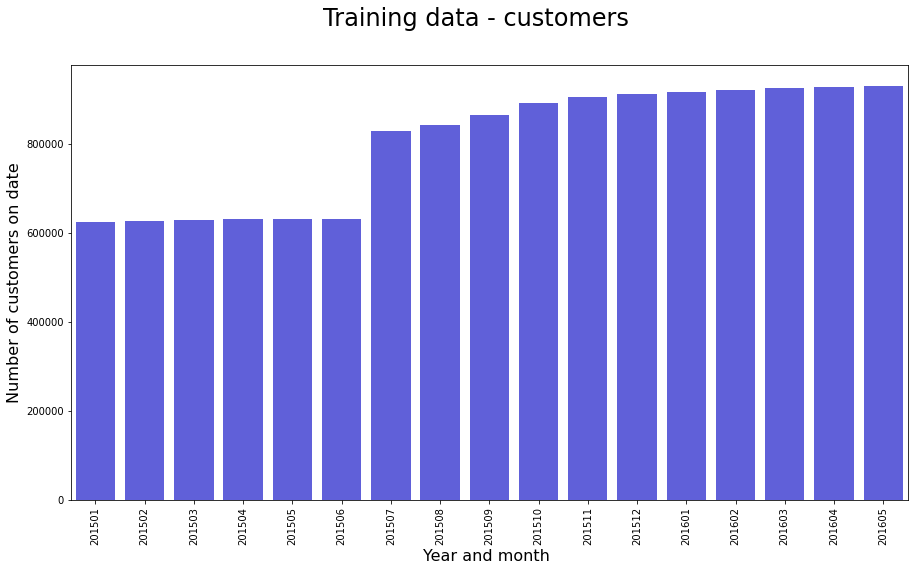

In [61]:
yearmonth = train_df['fecha_dato'].apply(
    lambda x: (100*x.year) + x.month
).value_counts()

plot_dates(yearmonth, 'Training data - customers')

# Cleaning the dataset

In [62]:
print("Training NaN values percentages \n\n",(train_df.isna().sum()/train_df.shape[0])*100)

Training NaN values percentages 

 fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1   

In [0]:
def nan_value_check(value):
    check = str(val).replace(' ', '').lower()
    if check == '?' or check == 'na' or check == 'nan':
        return True
    else:
        return False

## Removing the obvious features

We can clearly see that 'ult_fec_cli_1t' and 'conyuemp' should be removed, because they have almost 100% NaN values, which we cannot use for anything.

In [0]:
# remove columns with too many NaN values
drop_features = ['ult_fec_cli_1t', 'conyuemp']
#nomprov and cod_prov are the same information, and the encoding creates too many columns
drop_features.append('nomprov')
drop_features.append('cod_prov')
#tipodom has only one value
drop_features.append('tipodom')
#the encoding of canal_entrada and pais_residencia creates too many columns
drop_features.append('canal_entrada')
drop_features.append('pais_residencia')

In [0]:
train_df = train_df.drop(drop_features, axis=1)

In [0]:
columns_date.remove(drop_features[0])
columns_cat.remove(drop_features[1])
columns_cat.remove(drop_features[2])
columns_cat.remove(drop_features[3])
columns_cat.remove(drop_features[4])
columns_cat.remove(drop_features[5])
columns_cat.remove(drop_features[6])

## The feature 'renta'

This feature has nan values, but not enough to where we want to drop it. Instead, we choose to prepare it for imputation.

In [0]:
# make nan values into numpy nan values
train_df['renta'] = train_df['renta'].fillna(np.nan)

We have chosen to impute the values for renta, since the feature could potentially have good predictive power, in terms of which products a customer might want to purchase.

In [68]:
print("Number of Nan values in column renta before the process:")
print(train_df['renta'].isna().sum())

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
train_df['renta'] = imputer.fit_transform(train_df['renta'].values.reshape(-1, 1))

print("\nAfter the imputation:")
print(train_df['renta'].isna().sum())

Number of Nan values in column renta before the process:
2794375

After the imputation:
0


## The rest of the data

We choose to drop the rest of the rows that contains NaN values, since it represents a low percentage.

In [0]:
train_df['age'] = train_df['age'].str.strip()
train_df['antiguedad'] = train_df['antiguedad'].str.strip()

In [0]:
train_df = train_df.dropna(axis=0, how='any')

In [0]:
train_df['age'] = train_df['age'].astype(np.float64)
train_df['antiguedad'] = train_df['antiguedad'].astype(np.float64)

## The feature "indrel_1mes"

This feature can take only 5 different values, but actually, we can more types because some of the numbers are "float" while others are "string".


In [0]:
new_vals = []
for val in train_df["indrel_1mes"]:
  if type(val)=='str':
    val = float(val)
  new_vals.append(val)
train_df["indrel_1mes"] = np.array(new_vals, dtype=float)

## A quick check on the total number of NaN values

In [73]:
train_nan_values = 0

for name, values in train_df.iteritems():
    for val in values:
        if nan_value_check(val):
            train_nan_values += 1
            
print(f'There are {train_nan_values} NaN values in training dataset')

There are 0 NaN values in training dataset


# Preparing X and Y values

In this section, we want to prepare our inputs and outputs of the model. In particular, we want to include the prior information of which products the customer is already paying for.

In [0]:
y_variables = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1',
       'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1',
       'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
       'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
       'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
       'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1',
       'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
       'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1',
       'ind_recibo_ult1']

In [0]:
X_cat = np.concatenate([pd.get_dummies(train_df[x]) for x in columns_cat], axis=1)

#We don't need the codpers to make predictions based on the profile
X_num = train_df[columns_num[:-1]]

X = np.concatenate([X_cat, X_num], axis=1)

mat = train_df[y_variables].values
Y = mat[:].astype("int")

In [0]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [0]:
filter = []
for i in range(Y.shape[0]):
  filter.append(sum(Y[i]) == 1)

X = X[filter]
Y = Y[filter]

#Functions to assess the accuracy of the model

For the general accuracy:

In [0]:
def accuracy(y_hat, y_test):
  return 1.0*np.sum(y_hat == y_test) / len(y_test)

Then, we check the number of times where a customer has bought a product, and if this product has been predicted by the model

In [0]:
def accuracy_2(y_hat, y_test):
  correct = 0
  for i in range(len(y_test)):
    if y_test[i] == 1:
      correct += y_hat[i]

  if sum(y_test) > 0:
    return 1.0*correct/sum(y_test)
  else:
    return "This product has never been bought by the customers, and has been predicted \"bought\" " + str(sum(y_hat)) + " times by the model"

Finally, we count the number of times where we have predicted something, and this prediction was correct

In [0]:
def accuracy_model(y_hat, y_test):
  correct = 0
  for i in range(len(y_hat)):
    if y_hat[i] == 1:
      correct += y_test[i]
      
  if sum(y_hat) > 0:
    return 1.0*correct/sum(y_hat)
  else:
    return "This product has never been predicted as bought by the model, and has been bought " + str(sum(y_test)) + " times by the customers"

This function will compute the accuracy of a full line of predictions:

In [0]:
def accuracy_full_line(y_hat, y_test):
  correct = 0
  nb_products = len(y_hat[1])
  for i in range(len(y_hat)):
    test = 0
    for j in range(nb_products):
      test += (y_hat[i][j] == y_test[i][j])
    if test == nb_products:
      correct += 1
  return correct/len(y_test)

Thess functions return the accuracy of the predictions by products for each line

In [0]:
def accuracy_by_product(y_hat, y_test):
  E = []
  for i in range(len(y_hat[1])):
    E.append(accuracy(y_hat[:,i],y_test[:,i]))
  return E

def accuracy_2_by_product(y_hat, y_test):
  E = []
  for i in range(len(y_hat[1])):
    E.append(accuracy_2(y_hat[:,i],y_test[:,i]))
  return E

def accuracy_model_by_product(y_hat, y_test):
  E = []
  for i in range(len(y_hat[1])):
    E.append(accuracy_model(y_hat[:,i],y_test[:,i]))
  return E

#Baseline

###For only one product: (product number 7)
For this first example, we just try to predict for one product, and the prediction is based on the features in "columns_cat"

In [99]:
Y_one_product = Y[:,2]

print("number of 1 values :", (sum(Y_one_product)))

number of 1 values : 1951346


In [100]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y_one_product[ix_train]
Y_test = Y_one_product[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 1741176
num test: 580392


In [101]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 5000)
logreg.fit(X_train, Y_train)

# make predictions for test set
Y_hat = logreg.predict(X_test)
print("predictions:", Y_hat)
print("true values:", Y_test)

# evaluate prediction accuracy
print("Accuracy:", accuracy(Y_hat, Y_test))
print("Accuracy (measure 2):", accuracy_2(Y_hat, Y_test))
print("Accuracy (measure 3):", accuracy_model(Y_hat, Y_test))

predictions: [1 1 1 ... 1 1 1]
true values: [1 0 1 ... 0 1 1]
Accuracy: 0.8459058705151001
Accuracy (measure 2): 0.9803917951366896
Accuracy (measure 3): 0.8569066217572022


In [102]:
print(sum(Y_hat))
print(sum(Y_test))

558160
487857


###For all the products:

In [103]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y[ix_train]
Y_test = Y[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 1741176
num test: 580392


In [104]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
Y_hat = dtc.predict(X_test)

In [106]:
print(accuracy_full_line(Y_hat, Y_test))
print(accuracy_by_product(Y_hat, Y_test))
print(accuracy_2_by_product(Y_hat, Y_test))
print(accuracy_model_by_product(Y_hat, Y_test))

0.9799824945898634
[1.0, 1.0, 0.985087664888558, 0.9999913851328068, 0.9964299990351349, 0.9997363850638878, 0.9982115535706901, 0.9963369584694483, 0.9990316889274835, 0.9984079725426953, 0.9999793243187363, 0.9988507767164262, 0.9968021612978815, 0.9998466553639609, 0.999908682407752, 0.9998707769921019, 0.9998552702311542, 0.9989886145915174, 0.9995520269059532, 0.9998070269748721, 0.9999155743015066, 1.0, 0.9999879391859295, 0.9981064521909331]
[1.0, 'This product has never been bought by the customers, and has been predicted "bought" 0 times by the model', 0.9915826054172122, 0.926829268292683, 0.739071303672042, 0.991509518276879, 0.8233788395904437, 0.9652915676129212, 0.955372301722047, 0.4093886462882096, 0.7894736842105263, 0.8893280632411067, 0.8844492440604752, 0.9434832756632064, 0.9572072072072072, 0.9782460910944936, 0.9551122194513716, 0.9097794609044331, 0.9008498583569405, 0.9490881458966566, 0.9397781299524565, 'This product has never been bought by the customers, an

#And now we will use Pyro. First model: predictions for one product based on the profile of the customers

First we use Pyro for one product

In [0]:
Y_one_product = Y[:,2]

In [108]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y_one_product[ix_train]
Y_test = Y_one_product[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 1741176
num test: 580392


In [0]:
def first_model(X, obs=None):
    input_dim = X.shape[1]
    n_cat = 2

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 5.*torch.ones(1, n_cat)))  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 5.*torch.ones(input_dim, n_cat))) # Priors for the regression coeffcients
    
    
    with pyro.plate("data"):
      y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [111]:
%%time

# Define guide function
guide = AutoDiagonalNormal(first_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 5000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(first_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, Y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[0] ELBO: 4361134.1
CPU times: user 4min 3s, sys: 1.62 s, total: 4min 4s
Wall time: 1min 54s


Once converged, let's extract the posterior samples for the latent variables in the model using Pyro's Predictive class:

In [0]:
from pyro.infer import Predictive

predictive = Predictive(first_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha"))
samples = predictive(X_train, Y_train)

Lets plot the posterior distributions of the parameters:

In [113]:
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
print(beta_samples.shape)
print(alpha_samples.shape)

(2000, 30, 2)
(2000, 1, 2)


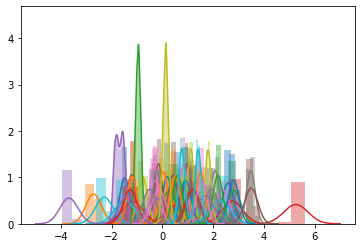

In [114]:
#attempt to plot the beta, not very successful, there are too much beta
for c in range(beta_samples.shape[1]):
    sns.distplot(beta_samples[:,c])
#plt.legend(["beta[%d]" % c for c in range(119)])
plt.show()

We can now use the inferred posteriors to make predictions:

In [0]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [118]:
# make predictions for test set
Y_hat = alpha_hat + np.dot(X_test, beta_hat)
Y_hat = np.argmax(Y_hat, axis=1)

print(accuracy(Y_hat, Y_test))
print(accuracy_2(Y_hat, Y_test))
print(accuracy_model(Y_hat, Y_test))

0.7844715295868999
0.8677967837754789
0.874928486010108


#Second model: predictions for all the products based on the profile of the customers

In [121]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
Y_train = Y[ix_train]
Y_test = Y[ix_test]
print("num train: %d" % len(Y_train))
print("num test: %d" % len(Y_test))

num train: 1741176
num test: 580392


In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

#These X_train and Y_train can be used if the computation time is too long with all the data
#X_train = torch.tensor(X_train[:2000,:]).float()
#Y_train = torch.tensor(Y_train[:2000,:]).float()

In [0]:
def categorical_model(X, obs=None):
    input_dim = X.shape[1]
    n_cat = obs.shape[1]

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 5.*torch.ones(1, n_cat)))
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 5.*torch.ones(input_dim, n_cat)))

    with pyro.plate("data"):     
        y = pyro.sample("y", dist.OneHotCategorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [124]:
%%time

# Define guide function
guide = AutoDiagonalNormal(categorical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 6000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(categorical_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, Y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 20461602.7
[500] ELBO: 1194236.1
CPU times: user 44min 17s, sys: 29.3 s, total: 44min 46s
Wall time: 26min 54s


In [125]:
from pyro.infer import Predictive

predictive = Predictive(categorical_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha"))

samples = predictive(X_train, Y_train)

beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
print(beta_samples.shape)
print(alpha_samples.shape)

# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

(2000, 30, 24)
(2000, 1, 24)


In [126]:
# make predictions for test set
Y_hat = alpha_hat + np.dot(X_test, beta_hat)

#rebuild matrix
Y_hat_arg=np.argmax(Y_hat,axis=1)
Y_hat_pred=np.zeros((Y_hat.shape[0],Y_hat.shape[1]))
for i in range(Y_hat.shape[0]): 
    Y_hat_pred[i,Y_hat_arg[i]]=1



# evaluate prediction accuracy
print("Accuracy:",accuracy_full_line(Y_hat_pred, Y_test))
print(sum(Y_hat))

Accuracy: 0.8593261106286786
[-1279637.25726637 -2335867.7530968   3467521.31552098 -2834129.04624464
   141933.92860032  -593662.25860794  -800274.92410932   238482.59820299
  -122203.45711965   265179.80719329 -3689049.42268077  -913959.73133382
   355893.7277913  -1975667.36233524   118269.05668018 -1690071.50654702
 -1064709.6839595   -197723.75317242 -1867085.31164636 -1712744.33076346
 -1256758.89575898 -2689785.87571767 -2242728.20943523  -277852.68912452]


#Third model: hierarchical model

So now, we complexify a little bit the model. Our assumption that we can use the same parameters beta for all the observations is too strong, because it means that all individuals give the same importance to all the features and have the same biases.

In [0]:
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,20))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [131]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 5)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [132]:
ind = km.labels_
print(ind)

[3 1 0 ... 0 3 3]


In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
Y_train = Y[ix_train]
Y_test = Y[ix_test]

In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train.float()
Y_train = torch.tensor(Y_train).float()
ind_train = torch.tensor(ind_train).long()
n_ind = max(ind_train) + 1

#X_train = torch.tensor(X_train[:2000,:]).float()
#Y_train = torch.tensor(Y_train[:2000,:]).float()
#ind_train = torch.tensor(ind_train[:2000]).long()
#n_ind = max(ind_train) + 1

In [0]:
def hierarchical_model(X, ind, n_ind, obs=None):
    input_dim = X.shape[1]
    n_cat = 24

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 10.*torch.ones(n_cat))) # Prior for the bias mean
    alpha_sigma = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.*torch.ones(n_cat))) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 10.*torch.ones(input_dim, n_cat))) # Priors for the regression coefficents
    
    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(1)) # Draw the individual parameter for each individual

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta)
        y = pyro.sample("y", dist.OneHotCategorical(logits=logits), obs=obs) # If you use logits you don't need to do sigmoid
        
    return y

In [323]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 5000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train, n_ind, Y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 92378.1
[500] ELBO: 26582.1
[1000] ELBO: 10937.9
[1500] ELBO: 8639.3
[2000] ELBO: 7811.5
[2500] ELBO: 8259.1
[3000] ELBO: 8832.8
[3500] ELBO: 7500.8
[4000] ELBO: 7761.7
[4500] ELBO: 7352.5
CPU times: user 4min 46s, sys: 882 ms, total: 4min 47s
Wall time: 1min 36s


In [0]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train, ind_train, n_ind, Y_train)

In [0]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [186]:
# make predictions for test set
Y_hat = alpha_hat[ind_test,:] + np.dot(X_test, beta_hat)

Y_hat_arg=np.argmax(Y_hat,axis=1)
Y_hat_pred=np.zeros((Y_hat.shape[0],Y_hat.shape[1]))
for i in range(Y_hat.shape[0]): 
    Y_hat_pred[i,Y_hat_arg[i]]=1

# evaluate prediction accuracy
print("Accuracy:",accuracy_full_line(Y_hat_pred, Y_test))

Accuracy: 0.4078428517696162


#Fourth model: add the product trends

The dataset contains information about the products previously bought by some customers. We can use this to observ which products are the most popular

In [0]:
products = train_df[y_variables]

popular_products_vector = np.zeros(products.shape[1])

for i, (name, values) in enumerate(products.iteritems()):
    for val in values:
      popular_products_vector[i] += val

popular_products_vector /= products.shape[0]

#normalization
popular_products_vector = (popular_products_vector-min(popular_products_vector)) / (max(popular_products_vector)-min(popular_products_vector))

In [0]:
#Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(Y))
perm = np.random.permutation(len(Y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
Y_train = Y[ix_train]
Y_test = Y[ix_test]

In [0]:
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
ind_train = torch.tensor(ind_train).long()
n_ind = max(ind_train) + 1

#X_train = torch.tensor(X_train[:2000,:]).float()
#Y_train = torch.tensor(Y_train[:2000,:]).float()
#ind_train = torch.tensor(ind_train[:2000]).long()
#n_ind = max(ind_train) + 1

popular_products_vector = torch.tensor(popular_products_vector).float()

In [0]:
def final_model(X, ind, n_ind, products, obs=None):
    input_dim = X.shape[1]
    n_cat = 24
    n_products = products.shape[0]

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 10.*torch.ones(n_cat))) # Prior for the bias mean
    alpha_sigma = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.*torch.ones(n_cat))) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 10.*torch.ones(input_dim, n_cat))) # Priors for the regression coefficents
    beta_products = pyro.sample("beta_product", dist.Normal(torch.zeros(n_products, n_cat), 10.*torch.ones(n_products, n_cat)))

    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(1)) # Draw the individual parameter for each individual

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta) + products.matmul(beta_products)
        y = pyro.sample("y", dist.OneHotCategorical(logits=logits), obs=obs) # If you use logits you don't need to do sigmoid
        
    return y

In [139]:
%%time
# Define guide function
guide = AutoDiagonalNormal(final_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 1000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(final_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train, n_ind, popular_products_vector, Y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 42002299.1
[500] ELBO: 3969755.9
CPU times: user 1h 25min 24s, sys: 1min 26s, total: 1h 26min 50s
Wall time: 52min 18s


In [0]:
from pyro.infer import Predictive

predictive = Predictive(final_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma", "beta_product"))
samples = predictive(X_train, ind_train, n_ind, popular_products_vector, Y_train)

In [0]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()
beta_product_hat = samples["beta_product"].mean(axis=0).detach().numpy()

In [142]:
# make predictions for test set
Y_hat = alpha_hat[ind_test,:] + np.dot(X_test, beta_hat) + np.dot(popular_products_vector, beta_product_hat)

Y_hat_arg=np.argmax(Y_hat,axis=1)
Y_hat_pred=np.zeros((Y_hat.shape[0],Y_hat.shape[1]))
for i in range(Y_hat.shape[0]): 
    Y_hat_pred[i,Y_hat_arg[i]]=1

# evaluate prediction accuracy
print("Accuracy:",accuracy_full_line(Y_hat_pred, Y_test))

Accuracy: 0.8593278336021172
